In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert
from pygimli.viewer.mpl import drawStreams

In [32]:
def getABMN(scheme, idx):
    """ Get coordinates of four-point cfg with id `idx` from DataContainerERT
    `scheme`."""
    coords = {}
    for elec in "abmn":
        elec_id = int(scheme(elec)[idx])
        if elec_id >= 0:
            elec_pos = scheme.sensorPosition(elec_id)
            coords[elec] = elec_pos.x(), elec_pos.y()
        else:
            coords[elec] = -99, -99
    return coords

def plotABMN(ax, scheme, idx):
    """ Visualize four-point configuration on given axes. """
    coords = getABMN(scheme, idx)
    for elec in coords:
        x, y = coords[elec]
        if y > -99:
            if elec in "ab":
                color = "green"
            else:
                color = "magenta"
            ax.plot(x, y, marker=".", color=color, ms=10)
            ax.annotate(elec.upper(), xy=(x, y), ha="center", fontsize=10, bbox=dict(
                boxstyle="round", fc=(0.8, 0.8, 0.8), ec=color), xytext=(0, 20),
                        textcoords='offset points', arrowprops=dict(
                            arrowstyle="wedge, tail_width=.5", fc=color, ec=color,
                            patchA=None, alpha=0.75))
            ax.plot(coords["a"][0],)


In [ ]:
data = ert.DataContainer()
data.createSensor([0, 0])
data.createSensor([0.4, 0])
data.createSensor([0.5, 0])
data.createSensor([0.9, 0])
data.createFourPointData(0, 1, -1, 2, -1)
data.createFourPointData(1, 0, 3, 1, 2)
data.createFourPointData(2, 0, -1, 1, 2)
data.createFourPointData(3, 3, -1, 1, 2)
data.createGeometricFactors()
data.save("bla.shm", "a b m n k")

15/02/26 - 21:43:40 - pyGIMLi - INFO - Save RVector binary
15/02/26 - 21:43:40 - pyGIMLi - INFO - Cache stored: C:\Users\Thomas Guenther\AppData\Roaming\pygimli\Cache\2928177364846557044


1

In [ ]:
# %% create world and mesh
world = mt.createWorld(start=[-0.2, -0.4], end=[1.1, 0.4], worldMarker=True, marker=1)
nn = [world.createNode(p) for p in data.sensorPositions()]
world.createEdge(nn[0], nn[1], marker=1)
world.createEdge(nn[1], nn[2], marker=1)
world.createEdge(nn[2], nn[3], marker=1)


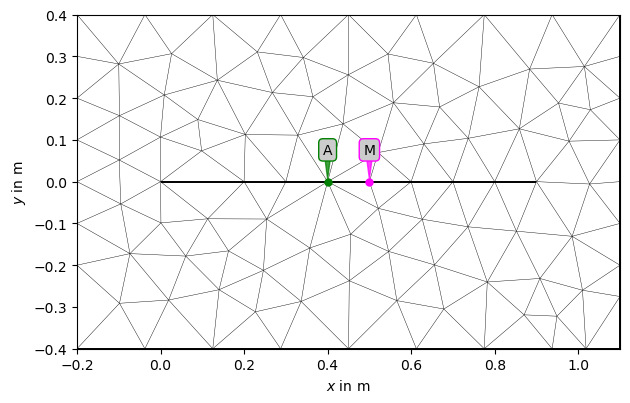

In [50]:
mesh = mt.createMesh(world, area=.01, quality=33, smooth=[1, 10])
ax, _ = pg.show(mesh)
plotABMN(ax, data, 0)
# ax.figure.savefig("wa-empty.svg")

In [51]:
mgr = ert.ERTManager(data)
pot = mgr.simulate(mesh=mesh, scheme=data, res=[[1, 100]], returnFields=1)

15/02/26 - 21:42:07 - pyGIMLi - INFO - Found 1 regions.
15/02/26 - 21:42:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/02/26 - 21:42:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/02/26 - 21:42:07 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 377 Cells: 688 Boundaries: 548


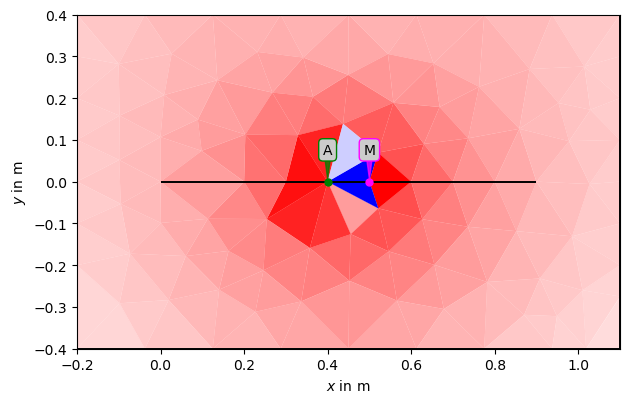

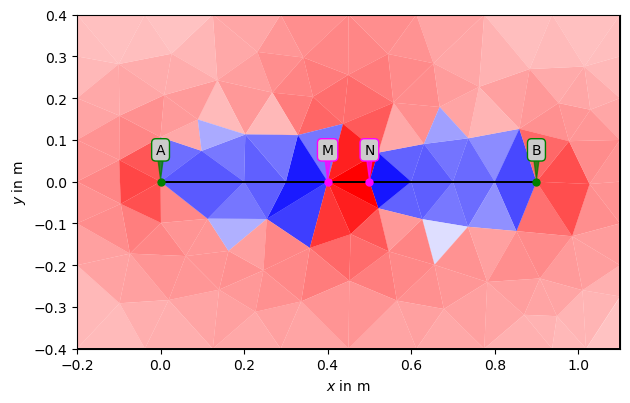

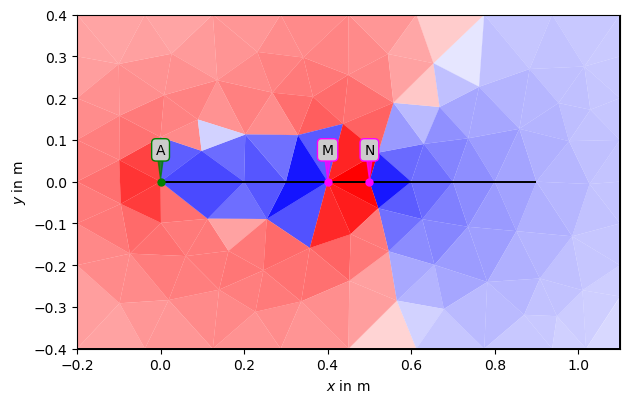

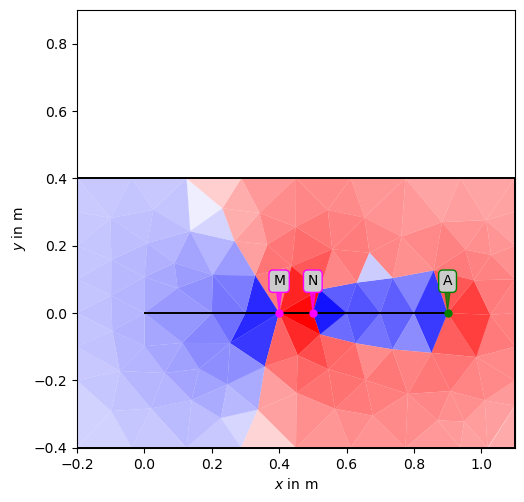

In [52]:
fop = ert.ERTModelling()
fop.setData(data)
fop.setMesh(mesh)
model = np.ones(mesh.cellCount())
fop.createJacobian(model)
for i in range(data.size()):
    sens = fop.jacobian()[i]
    normsens = pg.utils.logDropTol(sens/mesh.cellSizes(), 1e-2)
    normsens /= np.max(normsens)
    ax, _ = pg.show(mesh, normsens, cMap="bwr", colorBar=False, label="sensitivity", nLevs=3, cMin=-1, cMax=1)
    plotABMN(ax, data, i)
    # ax.set_ylim(-5, 1)
    ax.figure.savefig("sens_"+str(i)+".svg", bbox_inches="tight")